In [1]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import torch.nn.functional as F
from snntorch import functional as SF
import brevitas.nn as qnn 
from tqdm import tqdm
from pathlib import Path
from snntorch.functional import probe


import sys
sys.path.append('../src')
from my_network import *
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from assistant import Assistant
from stats import LearningStats
from utils import *

In [2]:

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = 'cuda'
print(f'Using device {device}')

Using device cuda


In [3]:
#path = f"{Path.home()}/snntorch_network/nni_experiments/inibitory_lif_no_encoder_best/results/ot6eqima/trials/oqxoS/Trained/network_best.npz"
#path = f"{Path.home()}/snntorch_network/nni_experiments/inibitory_lif_no_encoder_worst/results/ipk2erm5/trials/whXvC/Trained/network_best.npz"
path = f"{Path.home()}/snntorch_network/nni_experiments/inibitory_lif_no_encoder_balanced/results/4m8j0yfa/trials/yAnF7/Trained/network_best.npz"
#path = f"{Path.home()}/snntorch_network/nni_experiments/inibitory_lif_no_encoder_balanced_no_net_loss/results/uhrgfo1n/trials/TbZxT/Trained/network_best.npz" # best accuracy
#path = f"{Path.home()}/snntorch_network/nni_experiments/inibitory_lif_no_encoder_balanced_no_net_loss/results/uhrgfo1n/trials/bnh2o/Trained/network_best.npz" #same HP as the one with net_loss

data = np.load(path,allow_pickle=True)


linear1_w= data['linear1']
leaky1_vth= data['leaky1_vth']
leaky1_betas= 1-data['leaky1_betas'] 
leaky1_betas= leaky1_betas if leaky1_betas >= 0 else np.zeros(leaky1_betas.shape)
print(f"leaky1_betas: {leaky1_betas}")
print(f"leaky1_vth: {leaky1_vth}")
linear2_w = data['linear2']
leaky2_vth= data['recurrent_vth']
leaky2_betas= 1 - data['recurrent_betas']
leaky2_betas= leaky2_betas if  leaky2_betas >= 0 else np.zeros(leaky2_betas.shape)
print(f"leaky2_betas: {leaky2_betas}")
print(f"leaky2_vth: {leaky2_vth}")

recurrent_in_weights = data['input_dense']
recurrent_out_weights = - data['output_dense']
recurrent_vth = data['activation_vth']
recurrent_leaky_betas = 1 - data['activation_betas']
recurrent_leaky_betas= recurrent_leaky_betas if recurrent_leaky_betas >= 0 else np.zeros(recurrent_leaky_betas.shape)
print(f"recurrent_leaky_betas: {recurrent_leaky_betas}")
print(f"recurrent_vth: {recurrent_vth}")

linear3_w = data['linear3']
leaky3_vth= data['leaky2_vth']
leaky3_betas= 1 - data['leaky2_betas']
leaky3_betas= leaky3_betas if leaky3_betas >= 0 else np.zeros(leaky3_betas.shape)
print(f"leaky3_betas: {leaky3_betas}")
print(f"leaky3_vth: {leaky3_vth}")



leaky1_betas: 1.01234897878021
leaky1_vth: 2.195924758911133
leaky2_betas: 0.07083219289779663
leaky2_vth: 0.8788766860961914
recurrent_leaky_betas: 0.11015737056732178
recurrent_vth: 1.8151839971542358
leaky3_betas: 0.0
leaky3_vth: 0.830508828163147


In [4]:
batch_size = 512
slope = 10
# network parameters
num_inputs = 6 
num_steps = 40
net_hidden_1 = 180
net_hidden_2 = 400
net_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200
vth_in = 1.0
vth_out = 1.0
vth_recurrent = 1.0
vth_enc_value =  1.0
vth_std =  65 
beta_in = 0.5
beta_recurrent = 0.5
beta_back = 0.6
beta_out = 0.5
encoder_dim = 25
beta_std = 55
lr = 0.002
drop_recurrent =0.15
drop_back = 0.15
drop_out = 0.15
# spiking neuron parameters
beta = 0.8  # neuron decay rate

DATASET_NAME = 'data_watch_subset_0_40.npz'
DATASET_SUBSET = 'custom'
SUBSET_LIST = [0, 1, 4, 8, 9, 10, 14]
PATIENCE = 12
TRAIN_FOLDER_NAME = 'Trained'
NUM_WORKERS = 8
NET_OUTPUT_DIM = 7
NET_INPUT_DIM = 6
NUM_EPOCHS = 200
SEARCH_SPACE_SHUFFLE = 200
val_idx = 0



In [5]:
dataset = WisdmDatasetParser('../data/data_watch_subset_0_40.npz', norm=None, class_sublset='custom', subset_list=[0, 1, 4, 8, 9, 10, 14])
val_set = dataset.get_validation_set(subset=100, shuffle=False)
print(val_set[1])
val_set = (torch.Tensor(val_set[0][val_idx, :, :]).unsqueeze(0), val_set[1][val_idx])
#val_dataset = WisdmDataset(val_set)


(6,)
(6,)
ytrain shape (55404, 18)
yval shape (18468, 18)
ytest shape (18469, 18)
num classes train dataset: 7 occurrences of each class:[3127 3066 3044 3047 3150 3087 2973]
num classes eval dataset: 7 occurrences of each class:[1035  968 1048  996 1110 1053 1007]
num classes test dataset: 7 occurrences of each class:[1046 1061 1048 1036 1076 1026  982]
[5 1 4 0 1 2 3 6 2 1 0 1 0 0 5 3 3 6 1 0 4 6 1 2 0 4 5 5 2 4 5 0 4 6 3 0 3
 6 4 5 1 4 3 6 0 6 2 4 2 1 0 5 2 4 6 2 2 6 3 5 3 1 5 6 5 4 4 4 4 5 0 1 1 3
 0 4 1 2 5 1 0 2 4 4 2 6 6 6 0 0 1 0 0 0 5 3 5 6 0 3]


In [6]:

#val_loader  = DataLoader(dataset= val_dataset, batch_size=int(batch_size), shuffle=True, num_workers=NUM_WORKERS)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

grad = surrogate.fast_sigmoid(slope) #use slope for HPO

net_loss = regularization_loss(0.1, 0.03, 40)

net = ExInbitoryNetwork(NET_INPUT_DIM, int(linear1_w.shape[0]), int(linear2_w.shape[0]), NET_OUTPUT_DIM, grad,
                    vth_in=vth_in, vth_recurrent=vth_recurrent, vth_out=vth_out, vth_back=1.0,
                    beta_in=beta_in, beta_recurrent=beta_recurrent, beta_back=beta_back, beta_out=beta_out,
                    # encoder_dim=int(encoder_dim),
                    # vth_enc_value=vth_enc_value, vth_std=vth_std, beta_std=beta_std,
                    drop_recurrent=drop_recurrent, drop_back=drop_back, drop_out=drop_out,
                    time_dim=2, layer_loss=net_loss).to(device)

net.from_npz(path)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)

loss_fn = SF.loss.ce_count_loss()

stats = LearningStats()
assistant = Assistant(net, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler, lam=1.0)


labels = []
outputs = []


Using device cuda
type of self.linear2 is <class 'brevitas.nn.quant_linear.QuantLinear'>


/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/brevitas/nn/mixin/base.py:77: UserWarning: Keyword arguments are being passed but they not being used.
  warn('Keyword arguments are being passed but they not being used.')


In [7]:
def mtor_verbose(mtor):
    for name in mtor.monitored_layers:
        print(f"for layer {name}")
        #print(f"mtor[name]={mtor[name]}")
        print(f"len of mtor[{name}]={len(mtor[name])}")
        if isinstance(mtor[name][0], tuple):
            print(f"mtor[{name}][0] is tuple")
            new_spike_tensor = torch.stack([t[0] for t in mtor[name]])
            new_membrane_tensor = torch.stack([t[1] for t in mtor[name]])
            print(f"shape of new_spike_tensor={new_spike_tensor.shape}")
            print(f"shape of new_membrane_tensor={new_membrane_tensor.shape}")
        elif isinstance(mtor[name][0], torch.Tensor):
            print(f"mtor[{name}][0] is tensor")
            new_tensor = torch.stack(mtor[name])
            print(f"shape of new_tensor={new_tensor.shape}")

def create_raster_plot(data, name=None, figsize=None, tick_fontsize=14, label_fontsize=16):
    plt.clf()
    channels, timesteps = data.shape
    if figsize is None:
        x_size = timesteps / 2
        y_size = channels / 10 if channels > 100 else channels 
        figsize = (x_size, y_size)
    else:
        figsize = figsize

    plt.figure(figsize=figsize)
    print(data.shape)
    for channel in range(data.shape[0]):
        spike_times = np.where(data[channel])[0]
        plt.scatter(spike_times, [channel + 1] * len(spike_times), s=10, color='blue')

    # Place an invisible dot above the highest channel
    plt.scatter([0], [channels + 1], s=10, color='none', edgecolor='none')

    if name:
        plt.title(f"{name} Raster Plot")
    else:
        plt.title('Raster Plot')

    # Remove the y-ticks if there are more than 10 channels
    if channels > 10:
        plt.yticks([])  # Remove y-ticks
    else:
        plt.yticks(np.arange(1, data.shape[0] + 1), [f'N {i}' for i in range(data.shape[0])], fontsize=tick_fontsize)

    plt.xlabel('Timesteps', fontsize=label_fontsize)
    plt.ylabel('Channels', fontsize=label_fontsize)
    plt.ylim(0, data.shape[0] + 1)  # Extend y-axis limit to include the invisible dot
    plt.xlim(0, data.shape[1])
    plt.xticks(ticks=np.arange(data.shape[1]), labels=np.arange(data.shape[1]), fontsize=tick_fontsize)
    plt.grid(axis='x', color='black', linestyle='--', linewidth=0.2)
    plt.show()


# Generate the raster plot

def plot_signals(matrix, name=None, figsize=None, tick_fontsize=14, label_fontsize=16):
    """
    Plots the signal for each channel in the provided matrix.
    
    Parameters:
    matrix (np.ndarray): A 2D array where the first dimension represents channels
                         and the second dimension represents timesteps.
    """
    channels, timesteps = matrix.shape
    if figsize is None:
        
        x_size = timesteps / 2
        y_size = channels / 10 if channels > 100 else channels 
        figsize = (x_size, y_size)
    else:
        figsize = figsize

    plt.figure(figsize=figsize)
    for i in range(channels):
        plt.plot(matrix[i], label=f'Channel {i+1}')
    
    if name:
        plt.title(f"{name} Signal Plot")
    else:
        plt.title('Signal Plot')
    
    plt.xlabel('Timestep', fontsize=label_fontsize)
    plt.ylabel('Signal Value' , fontsize=label_fontsize)
    plt.xlim(0, matrix.shape[1])
    plt.xticks(ticks=np.arange(matrix.shape[1]), labels=np.arange(matrix.shape[1]))
    plt.grid(axis='x', color='black', linestyle='--', linewidth=0.2)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    # plt.legend(ncol=15, loc='upper center', bbox_to_anchor=(0.5, -0.05), facecolor='white', framealpha=1)
    plt.show()

def mtor_plot(mtor):
    for name in mtor.monitored_layers:
        print(f"for layer {name}")
        if isinstance(mtor[name][0], tuple):
            print(f"mtor[{name}][0] is tuple")
            new_spike_tensor = torch.stack([t[0] for t in mtor[name]])
            new_membrane_tensor = torch.stack([t[1] for t in mtor[name]])
            for i in range(new_spike_tensor.shape[1]):
                create_raster_plot(new_spike_tensor[:,i,:].cpu().numpy().T, name, figsize=(16, 10))
                plot_signals(new_membrane_tensor[:,i,:].cpu().numpy().T, figsize=(15, 10))
                
        elif isinstance(mtor[name][0], torch.Tensor):
            print(f"mtor[{name}][0] is tensor")
            new_tensor = torch.stack(mtor[name])
            create_raster_plot(new_tensor[:,i,:].cpu().numpy().T, figsize=(16, 10))
            plot_signals(new_tensor[:,i,:].cpu().numpy().T,figsize=(15, 10))


/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/torch/_tensor.py:1488: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1928.)
  return super().rename(names)
/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/snntorch/_neurons/leaky.py:211: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:311.)
  self.mem = torch.zeros_like(input_, device=self.mem.device)


torch.Size([1, 6, 40])


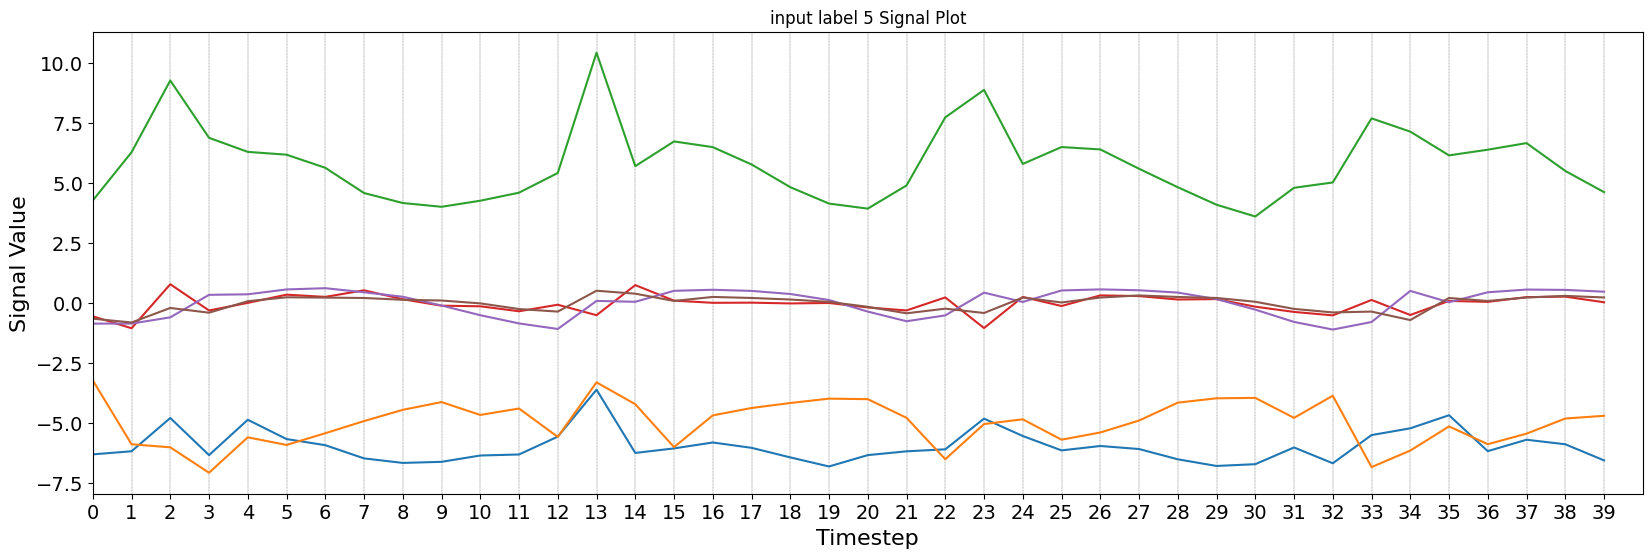

for layer leaky1
len of mtor[leaky1]=40
mtor[leaky1][0] is tuple
shape of new_spike_tensor=torch.Size([40, 1, 200])
shape of new_membrane_tensor=torch.Size([40, 1, 200])
for layer recurrent.recurrent.activation
len of mtor[recurrent.recurrent.activation]=40
mtor[recurrent.recurrent.activation][0] is tuple
shape of new_spike_tensor=torch.Size([40, 1, 500])
shape of new_membrane_tensor=torch.Size([40, 1, 500])
for layer leaky2
len of mtor[leaky2]=40
mtor[leaky2][0] is tuple
shape of new_spike_tensor=torch.Size([40, 1, 7])
shape of new_membrane_tensor=torch.Size([40, 1, 7])
for layer recurrent
len of mtor[recurrent]=40
mtor[recurrent][0] is tuple
shape of new_spike_tensor=torch.Size([40, 1, 500])
shape of new_membrane_tensor=torch.Size([40, 1, 500])
for layer leaky1
mtor[leaky1][0] is tuple
(200, 40)


<Figure size 640x480 with 0 Axes>

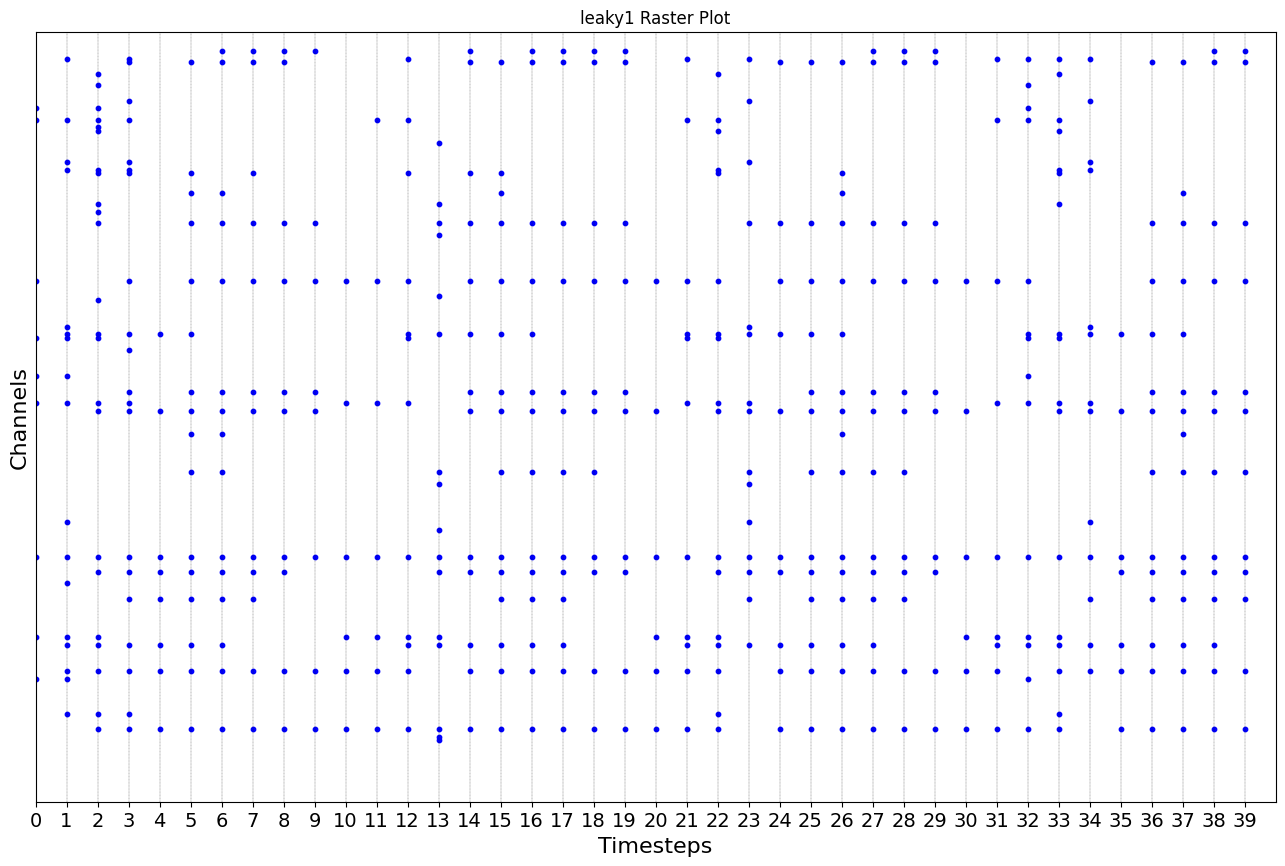

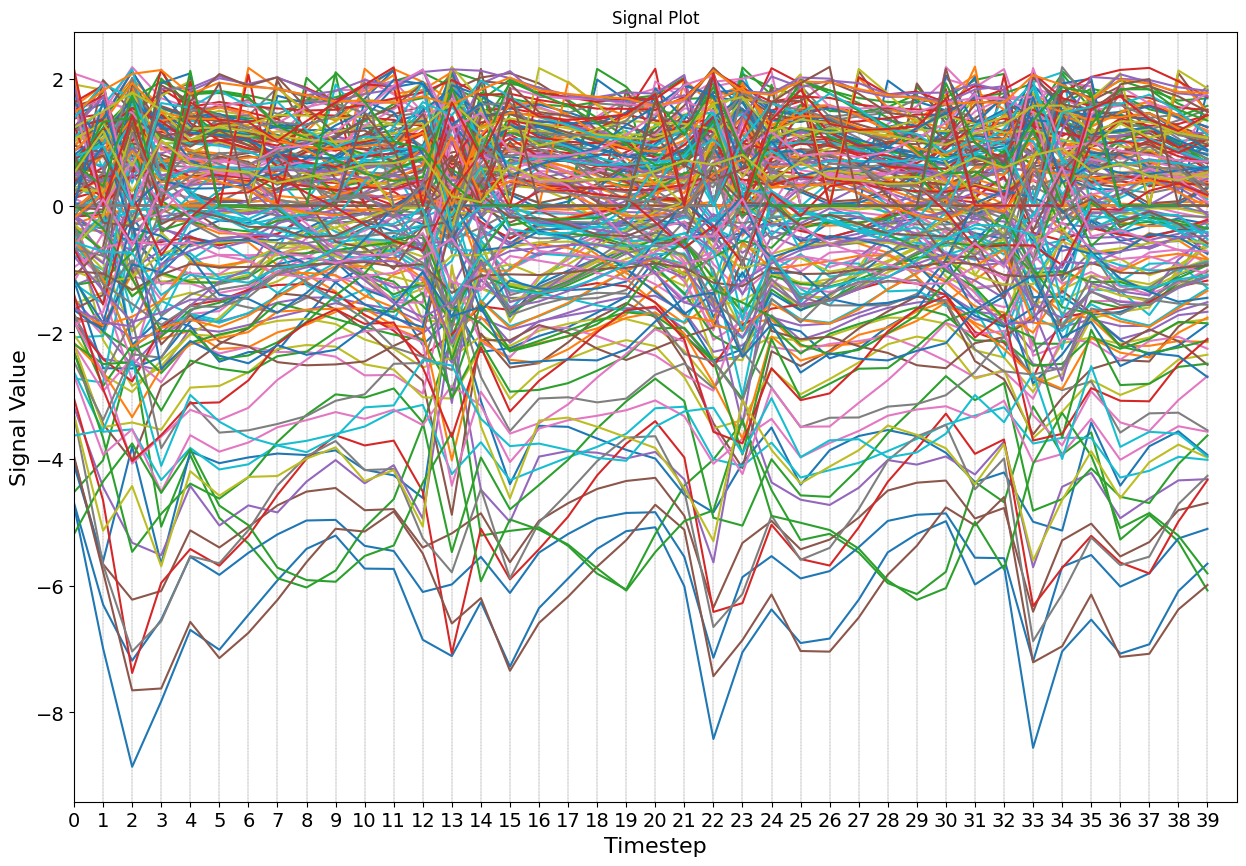

for layer recurrent.recurrent.activation
mtor[recurrent.recurrent.activation][0] is tuple
(500, 40)


<Figure size 640x480 with 0 Axes>

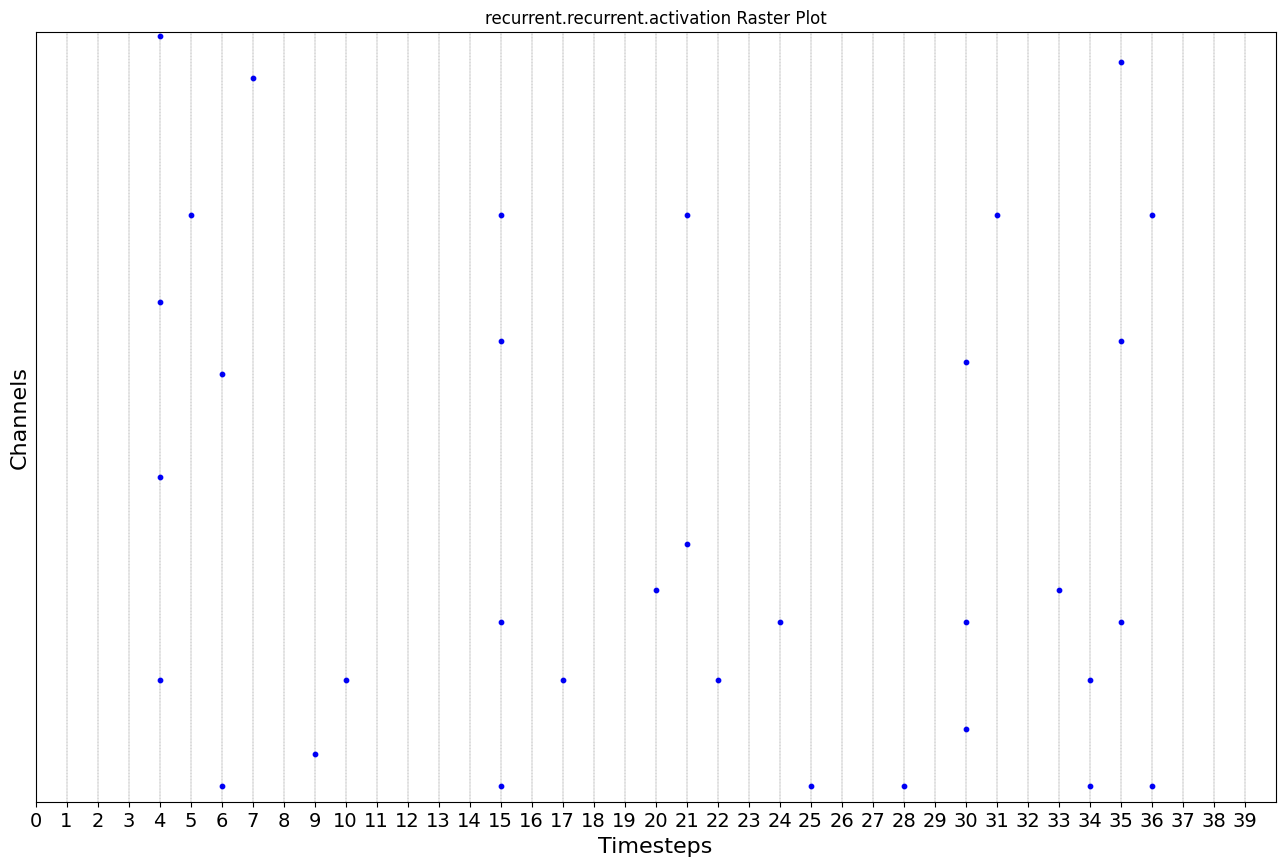

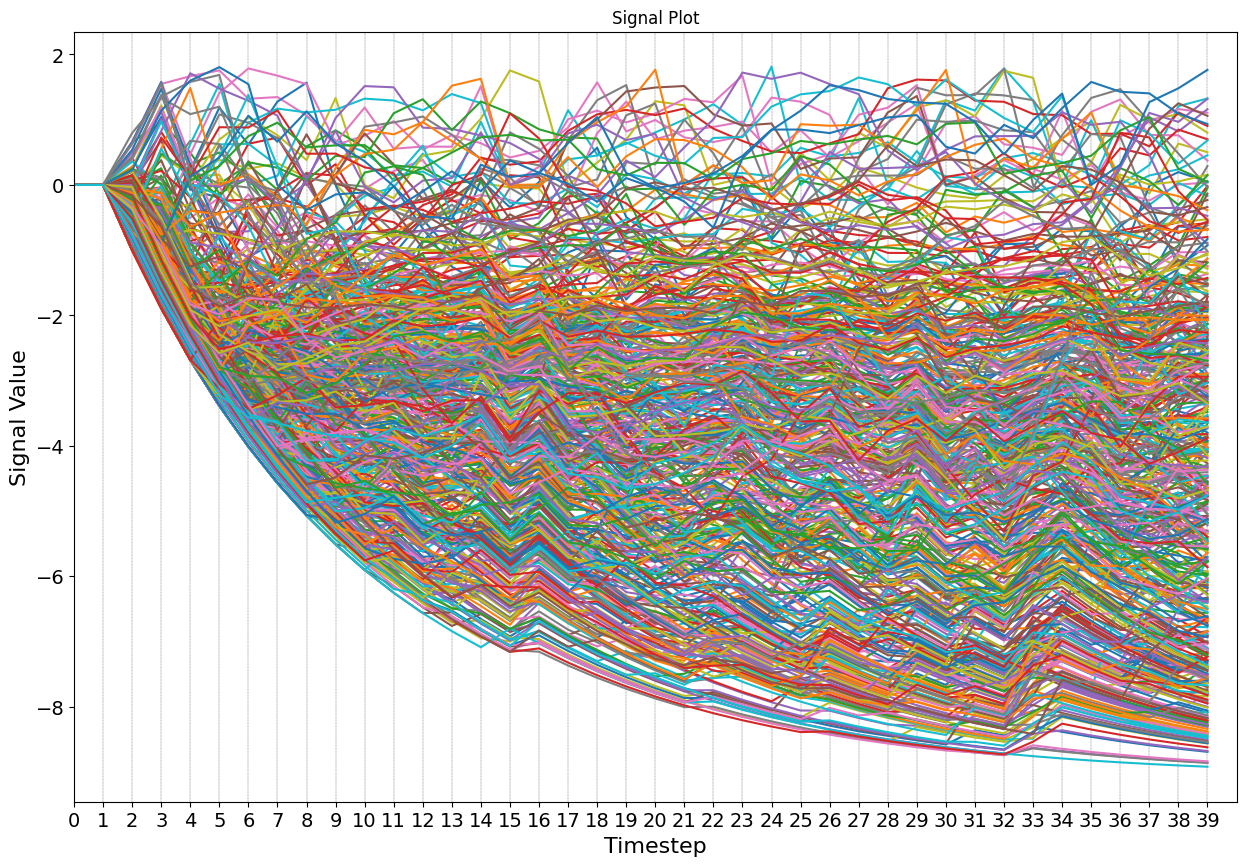

for layer leaky2
mtor[leaky2][0] is tuple
(7, 40)


<Figure size 640x480 with 0 Axes>

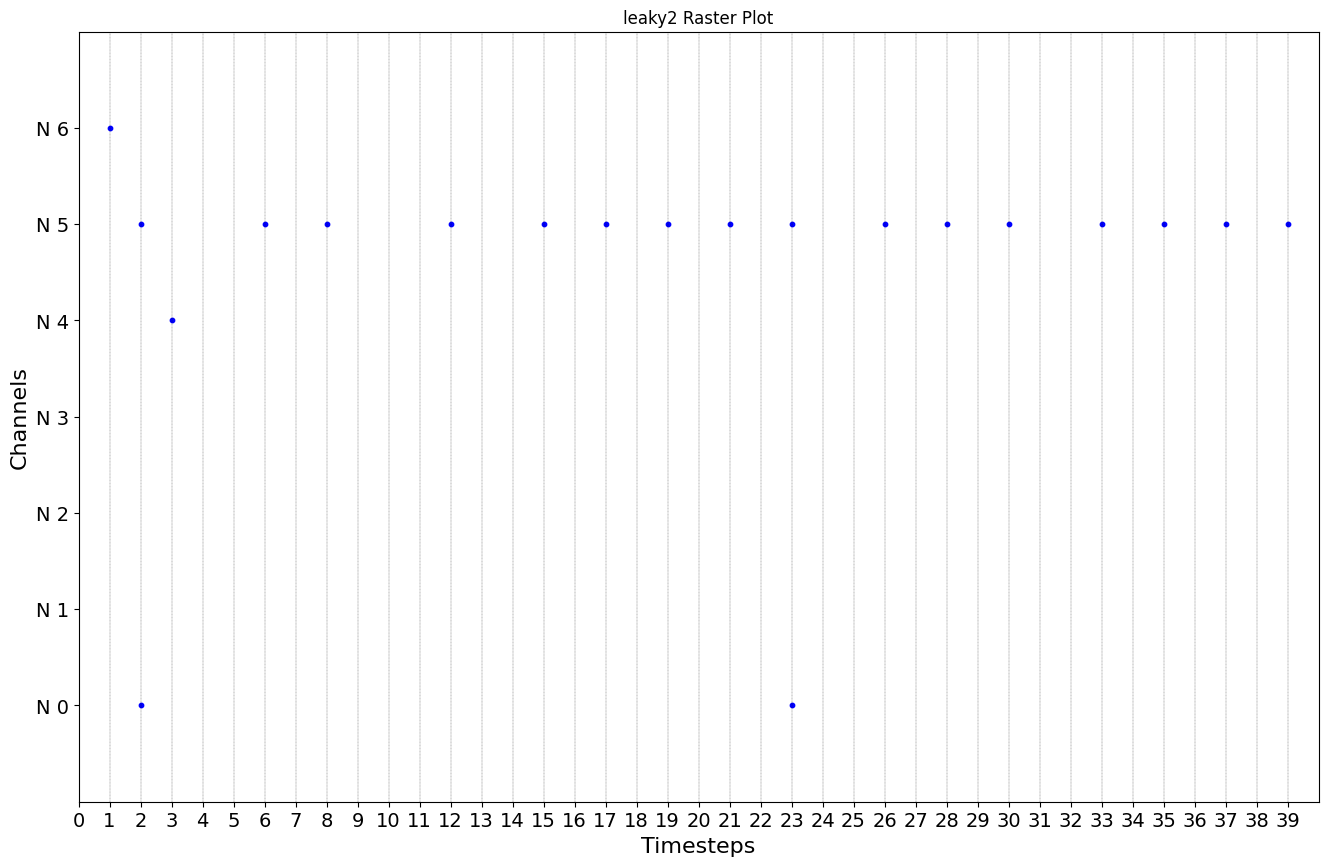

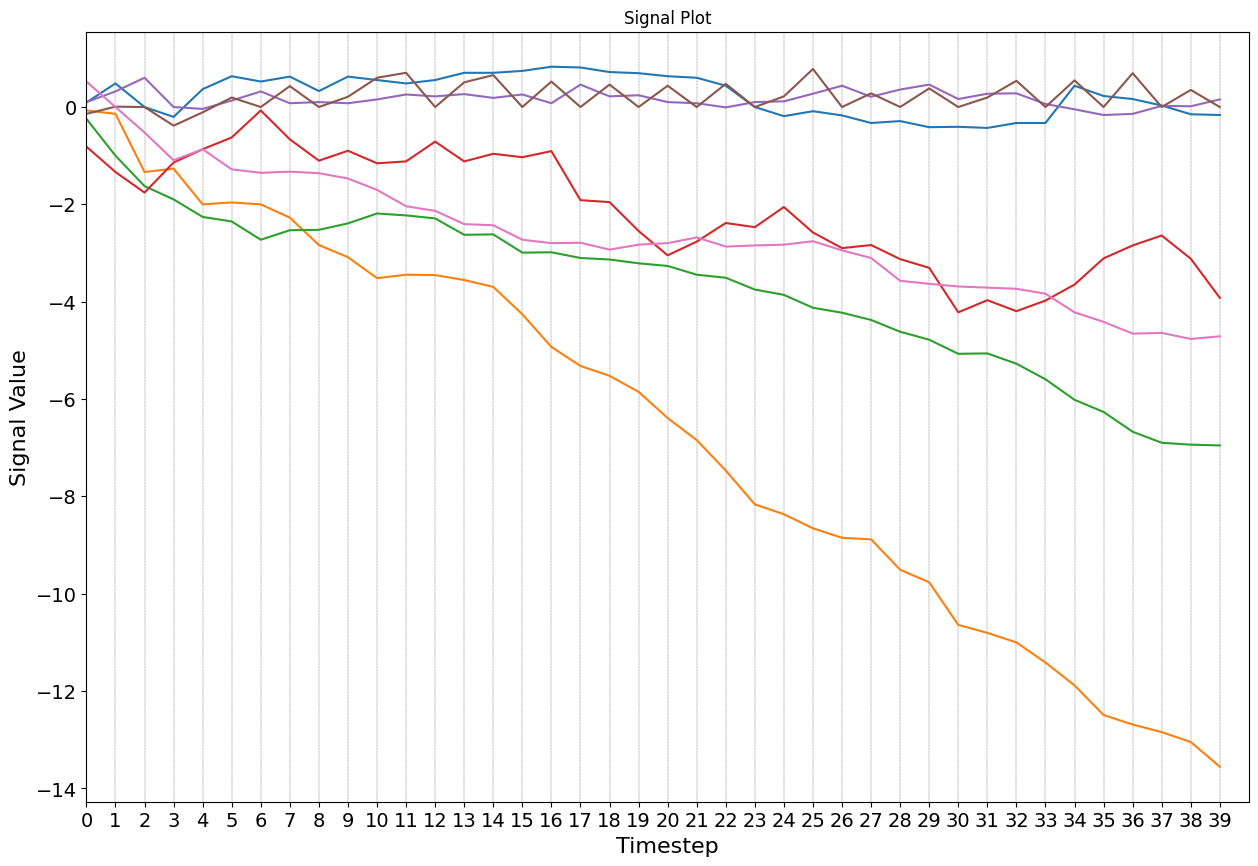

for layer recurrent
mtor[recurrent][0] is tuple
(500, 40)


<Figure size 640x480 with 0 Axes>

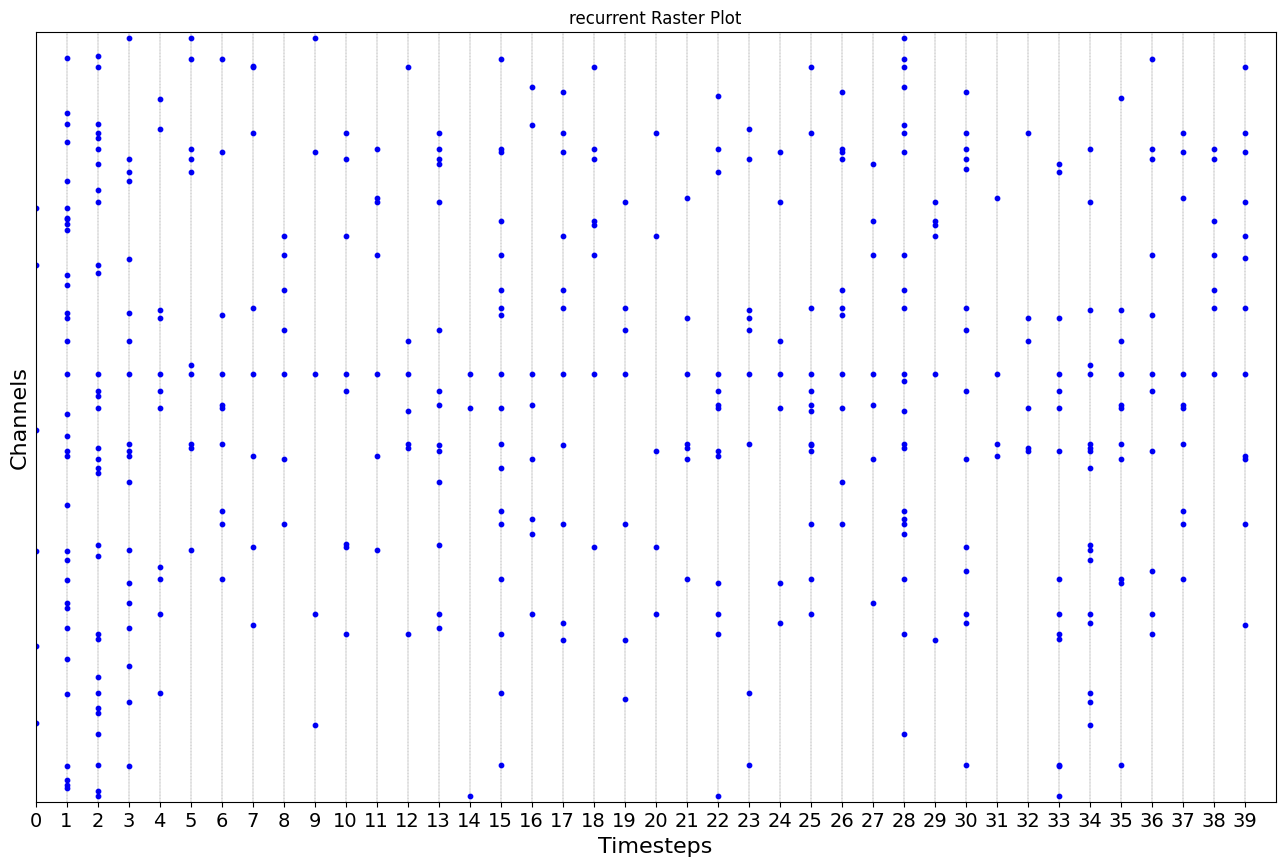

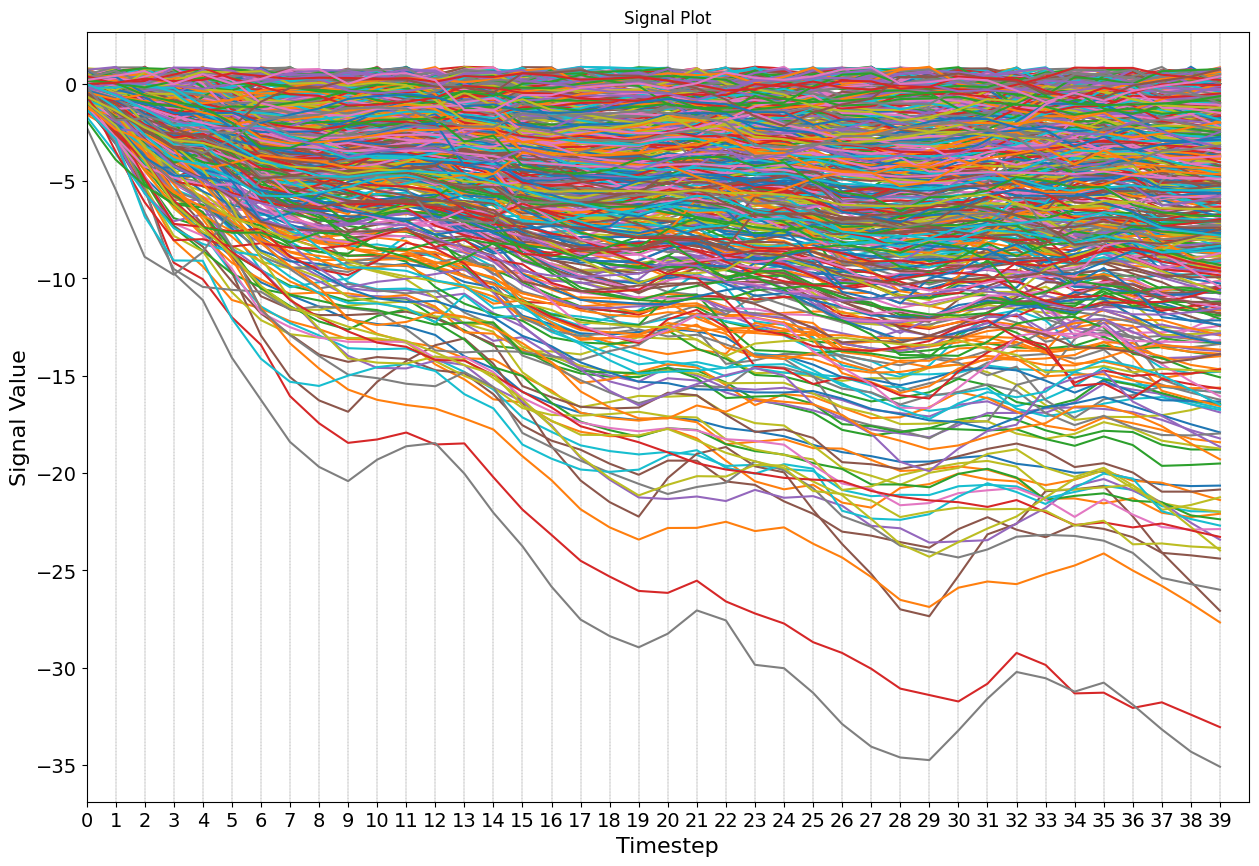

In [8]:

mtor = probe.OutputMonitor(net, instance=snn.Leaky)
mtor.enable()
mtor2 = probe.OutputMonitor(net, instance=snn.RLeaky)

with torch.no_grad():
    net.eval()
    data, label = val_set
    data = data.to(device)
    output = net(data)
    labels.append(label)
    outputs.append(output)
    print(data.shape)
    plot_signals(data.cpu().numpy()[0,:,:], f"input label {label}")
    mtor_verbose(mtor)
    mtor_verbose(mtor2)
    mtor_plot(mtor)
    mtor_plot(mtor2)